**Disclaimer:** Colab's free version works on a dynamic usage limit, which is not fixed and size is not documented anywhere, that is the reason free version is not a guaranteed and unlimited resources.
Basically, the overall usage limits and timeout periods, maximum VM lifetime, GPU types available, and other factors vary over time. Colab does not publish these limits, in part because they can (and sometimes do) vary quickly. They also allegedly measure compute against demand, so if you use during peak times it uses up your credits faster. In addition, if you’re using new Google accounts, Cclab doesn’t let you use it for as long. The account needs to be older to get more usage time.

**Disclaimer 2:** Google Colab notebooks have an idle timeout of 90 minutes and absolute timeout of 12 hours. This means, if user does not interact with his Google Colab notebook for more than 90 minutes, its instance is automatically terminated. Also, maximum lifetime of a Colab instance is 12 hours.

^ one method to avoid the 90-minute termination is to execute the following code in the console (Inspect Element):

function ClickConnect(){  
    console.log("Clicked on connect button");  
    document.querySelector("colab-connect-button").click()  
}  
setInterval(ClickConnect,60000)  

**Disclaimer 3:** Colab Pro? $10.00/month, gives 100 compute units. You are given a T4 GPU by default—the same as free tier, but a T4 GPU consumes 1.96 compute units per hour. If Colab Pro, you can choose "Premium GPU" from a drop down (e.g. a A100-SXM4-40GB is 15 compute units per hour)



# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import json

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

!pip install torchinfo
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.utils as vutils

import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install deeplake
import deeplake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 k

In [ ]:
seed = 3407
# "torch.manual seed(3407) is all you need" (Picard 2021)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # includes CUDA 

In [ ]:
print('CUDA version:', torch.version.cuda)
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA version: 11.8
PyTorch version: 2.0.1+cu118


In [ ]:
# experiment w/ diff values!

BATCH_SIZE = 64
IMG_SIZE = 128
EPOCHS = 10 # for now

# read if you want: why mini-batch sizes are typically powers of 2:
# https://stackoverflow.com/questions/44483233/is-using-batch-size-as-powers-of-2-faster-on-tensorflow

#  large-batch methods tend to converge to sharp minimizers of the training function. These minimizers are characterized by large positive eigenvalues in 
# ∇^2𝑓(𝑥) and tend to generalize less well. In contrast, small-batch methods converge to flat minimizers characterized by 
# small positive eigenvalues of ∇^2𝑓(𝑥)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

In [ ]:
ds = deeplake.load('hub://activeloop/wiki-art')

|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/wiki-art



\

hub://activeloop/wiki-art loaded successfully.



In [ ]:
class_names = np.unique(ds.labels.data()['text'])
n_class = len(class_names)

## Dataloader

In [ ]:
tform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(IMG_SIZE)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # summary statistics calculated from ImageNet, so they are standard practice. 
    # you can calculate the new mean and std on your training data but otherwise using the Imagenet pretrained 
    # model with its own mean and std is recommended. 
])

In [ ]:
# for reverting normalization for visualization purposes
invTrans = transforms.Normalize(
                mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                std=[1 / 0.229, 1 / 0.224, 1 / 0.225])

## Dataset

In [ ]:
class PaintingDataset(Dataset):
    '''
    '''
    def __init__(self, ds, transform = None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        image = self.ds.images[idx].numpy()
        label = self.ds.labels[idx].numpy(fetch_chunks = True).astype(np.int32)
        # When loading data sequentially, or when randomly loading samples from a tensor that fits 
        # into the cache (such as class_labels) it is recommended to set fetch_chunks = True. 
        # This increases the data loading speed by avoiding separate requests for each individual sample.
        # This is not recommended when randomly loading large tensors, because the data is deleted from the 
        # cache before adjacent samples from a chunk are used.

        if self.transform is not None:
            image = self.transform(image)

        sample = {"images": image, "labels": label}

        return sample

In [ ]:
dataset = PaintingDataset(ds, transform = tform)

## Dataloader

In [ ]:
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 0, shuffle = True, pin_memory=True)
# remark on pin_memory:
# If you load your samples in the Dataset on CPU and would like to push it during training to the GPU, 
# you can speed up the host to device transfer by enabling pin_memory.
# This lets your DataLoader allocate the samples in page-locked memory, which speeds-up the transfer.

## Gaussian Noise Function
#### (useful to inject into discriminator later)

In [ ]:
from skimage.util import random_noise

def gaussian_noise(img):
  gauss_img = torch.tensor(random_noise(img.detach().cpu(), mode='gaussian', mean=0, var=0.05, clip=True))
  gauss_img = gauss_img.to(device).float()
  return gauss_img

Text(0.5, 1.0, 'Image w/ Gaussian Noise')

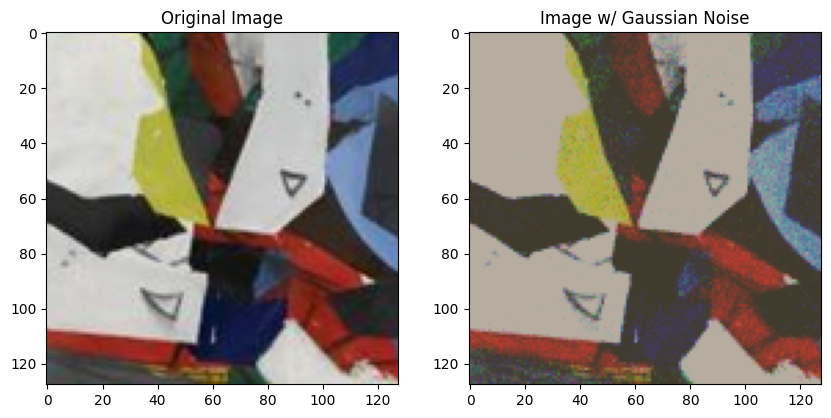

In [ ]:
noise_img = gaussian_noise(dataset[2023]['images'])

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(np.transpose(invTrans(dataset[2023]['images']), (1,2,0)))
ax[0].set_title("Original Image")
ax[1].imshow(np.transpose(invTrans(noise_img), (1,2,0)))
ax[1].set_title("Image w/ Gaussian Noise")

## Visualization

<ipython-input-50-ea39f1c89677>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,4,i+1)


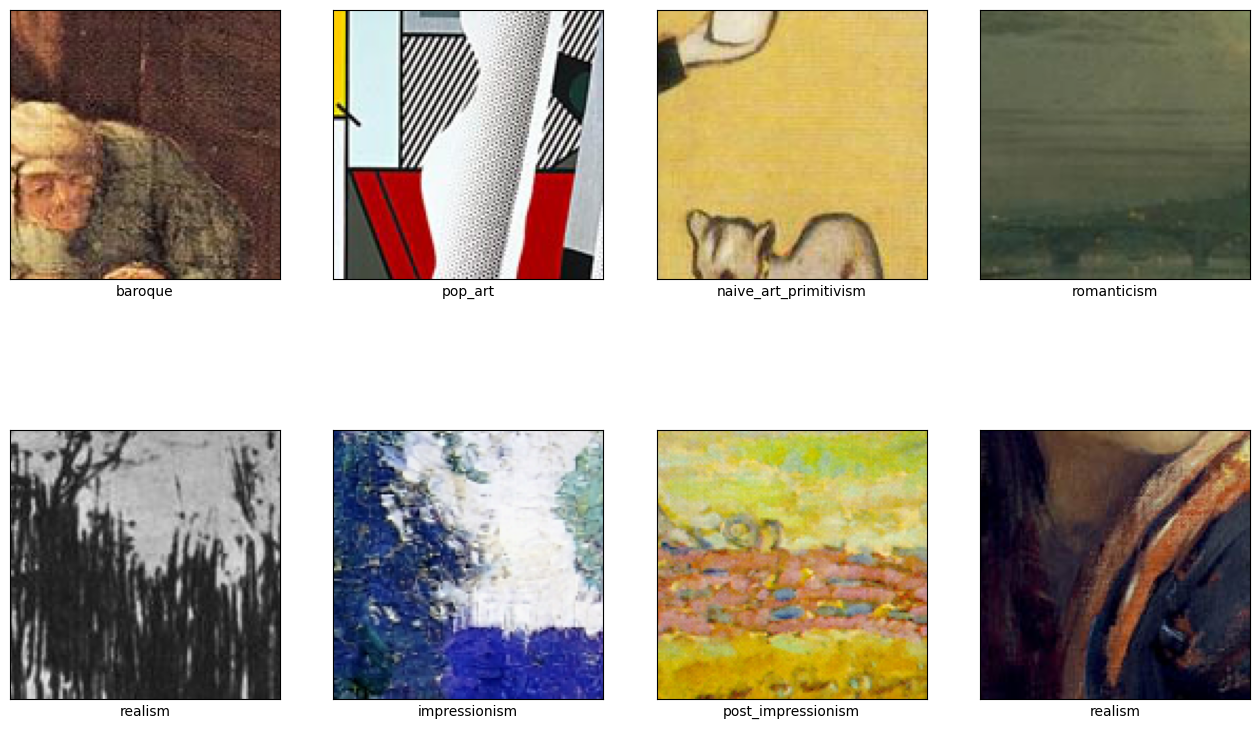

In [ ]:
plt.figure(figsize=(16,10))
plt.title('Training Images')

images, labels = next(iter(dataloader)).values()
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = invTrans(images[i]) # reverts image normalizations for display purposes  
    image = np.transpose(image.cpu(), (1,2,0))
    plt.imshow(image)
    plt.xlabel(class_names[labels[i]])
plt.show()

# Model

In [ ]:
# Remarks:

# Conv2D is mainly used when you want to detect features, e.g., in the encoder part of an autoencoder model, 
# and it may shrink your input shape. Conversely, Conv2DTranspose is used for creating features, for example,
# in the decoder part of an autoencoder model for constructing an image. It makes the input shape larger.

# In GANs, the recommendation is to not use pooling or fully-connected layers

## Generator

In [117]:
class Generator(nn.Module):
            
    def __init__(self):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(128, 512, kernel_size=5) # 128 just a hyperparameter for noise vector
        self.bn1 = nn.BatchNorm2d(512)
        self.conv2 = nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=3, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=3, padding=2)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=2)
        
        self.relu = nn.LeakyReLU()
        # some, like DCGAN's implementation, uses ReLU for the generator, but not for the discriminator
        # here we use LeakyRELU for both instead
        # LeakyRELU is popular in tasks where we may suffer from sparse gradients, 
        # for example, training GANs

        self.tanh = nn.Tanh()
        # note ReLU should only be used within hidden layers. for generator output layer we use tanh
        
    def forward(self, x):
        x = self.bn1(self.relu(self.conv1(x)))
        x = self.bn2(self.relu(self.conv2(x)))
        x = self.bn3(self.relu(self.conv3(x)))
        x = self.bn4(self.relu(self.conv4(x)))
        x = self.tanh(self.conv5(x))
        return x
    
        # We use relu before BN = design choice. BN needs to come last after relu to properly do its job of normalizing layer inputs

In [118]:
summary(Generator(), (64, 128, 1, 1))
# recall we feed the generator noise, not a painting
# so we're feeding it torch.randn(batch_size, size of noise "image", 1, 1, device=device)
# and we get out [batch_size, 3 (# of channels), image_size, image_size], in other words a properly sized image

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [64, 3, 128, 128]         --
├─ConvTranspose2d: 1-1                   [64, 512, 5, 5]           1,638,912
├─LeakyReLU: 1-2                         [64, 512, 5, 5]           --
├─BatchNorm2d: 1-3                       [64, 512, 5, 5]           1,024
├─ConvTranspose2d: 1-4                   [64, 256, 9, 9]           3,277,056
├─LeakyReLU: 1-5                         [64, 256, 9, 9]           --
├─BatchNorm2d: 1-6                       [64, 256, 9, 9]           512
├─ConvTranspose2d: 1-7                   [64, 128, 23, 23]         295,040
├─LeakyReLU: 1-8                         [64, 128, 23, 23]         --
├─BatchNorm2d: 1-9                       [64, 128, 23, 23]         256
├─ConvTranspose2d: 1-10                  [64, 64, 65, 65]          73,792
├─LeakyReLU: 1-11                        [64, 64, 65, 65]          --
├─BatchNorm2d: 1-12                      [64, 64, 65, 65]

In [119]:
# test = nn.Sequential(
#     nn.ConvTranspose2d(128, 512, kernel_size=5),
#     nn.BatchNorm2d(512),
#     nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2),
#     nn.BatchNorm2d(256),
#     nn.ConvTranspose2d(256, 128, kernel_size=3, stride=3, padding=2),
#     nn.BatchNorm2d(128),
#     nn.ConvTranspose2d(128, 64, kernel_size=3, stride=3, padding=2),
#     nn.BatchNorm2d(64),
#     nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=2),
# )

# input = torch.randn(64, 128, 1, 1)
# output = test(input)
# print(output.size())

## Discriminator

In [170]:
class Discriminator(nn.Module):
            
     # input 64 (batch size) x 3 (channels) x 128 x 128 (image size)
        
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        
        self.relu = nn.LeakyReLU(0.1)

        self.discriminate = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*4*4, 1),
            nn.Sigmoid())
        
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*4*4, 1024),
            nn.LeakyReLU(0.1),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, n_class))
            # no softmax, will apply later

    def forward(self, x):
        x = self.bn1(self.relu(self.conv1(gaussian_noise(x))))
        x = self.bn2(self.relu(self.conv2(gaussian_noise(x))))
        x = self.bn3(self.relu(self.conv3(gaussian_noise(x))))
        x = self.bn4(self.relu(self.conv4(gaussian_noise(x))))
        x = self.bn5(self.relu(self.conv5(gaussian_noise(x))))
        x = self.bn6(self.relu(self.conv6(gaussian_noise(x))))
            
        disc_p = self.discriminate(x)
        style_p = self.classify(x)
        return disc_p, style_p
    
        # note we use relu before BN, design choice. BN needs to come last after relu and pooling to properly
        # do its job of normalizing layer inputs

In [171]:
summary(Discriminator(), (64, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [64, 1]                   --
├─Conv2d: 1-1                            [64, 32, 129, 129]        1,568
├─LeakyReLU: 1-2                         [64, 32, 129, 129]        --
├─BatchNorm2d: 1-3                       [64, 32, 129, 129]        64
├─Conv2d: 1-4                            [64, 64, 64, 64]          32,832
├─LeakyReLU: 1-5                         [64, 64, 64, 64]          --
├─BatchNorm2d: 1-6                       [64, 64, 64, 64]          128
├─Conv2d: 1-7                            [64, 128, 32, 32]         131,200
├─LeakyReLU: 1-8                         [64, 128, 32, 32]         --
├─BatchNorm2d: 1-9                       [64, 128, 32, 32]         256
├─Conv2d: 1-10                           [64, 256, 16, 16]         524,544
├─LeakyReLU: 1-11                        [64, 256, 16, 16]         --
├─BatchNorm2d: 1-12                      [64, 256, 16, 16]        

In [156]:
# for testing

test2 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(512),
        
        # nn.Flatten(),
        # nn.Linear(512*4*4, 1),
        # nn.Sigmoid())
        
        # nn.Flatten(),
        # nn.Linear(512*4*4, 1024),
        # nn.LeakyReLU(0.1),
        # nn.Linear(1024, 512),
        # nn.LeakyReLU(0.1),
        # nn.Linear(512, n_class),
)

input2 = torch.randn(64, 3, 128, 128)
output2 = test2(input2)
print(output2.size())

torch.Size([64, 27])


In [ ]:
# ARCHIVED. old model architecture

# # for testing

# test2 = nn.Sequential(
#         nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1),
#         nn.BatchNorm2d(16),
#         nn.Conv2d(16, 32, kernel_size=5, stride=3, padding=2),
#         nn.BatchNorm2d(32),
#         nn.Conv2d(32, 64, kernel_size=3, stride=3, padding=2),
#         nn.BatchNorm2d(64),
#         nn.Conv2d(64, 128, kernel_size=3, stride=3, padding=2),
#         nn.BatchNorm2d(128),
#         nn.Conv2d(128, 1, kernel_size=3),
#         nn.Sigmoid()
#         # nn.Conv2d(128, n_class, kernel_size=3)
# )

# input2 = torch.randn(64, 3, 128, 128)
# output2 = test2(input2)
# print(output2.size())

In [123]:
# to-do: perhaps just follow the paper and use classic nn.init.normal_() rather than Xavier
# nn.init.normal_(model_layer.weight.data, 0, 0.02)

def weight_init(model_layer):
    '''
    TO-DO
    meant to be used with model.apply(weight_init) such that the function is called for each model layer
    '''
    layer_name = model_layer.__class__.__name__
    if layer_name.find('Conv') != -1:
        # Ads Xavier initialization to convolutional layers
        # design choice to use normal distribution rather than uniform.
        # Recall Xavier initialization initializes weights such that the variance of the 
        # activations are the same across every layer; this prevents the gradient from exploding or vanishing
        nn.init.xavier_normal_(model_layer.weight.data, 0, 0.02)
    elif layer_name.find('BatchNorm') != -1:
        # batchnorm layer only has dim 1 so cannot compute fan in fan out values for Xavier initialization
        nn.init.normal_(model_layer.weight.data, 1, 0.02)
        nn.init.constant_(model_layer.bias.data, 0)

# Initialization and setup

In [172]:
gen = Generator().to(device)
disc = Discriminator().to(device)

In [173]:
gen.apply(weight_init);
disc.apply(weight_init);

In [174]:
loss = nn.BCELoss() # BCELoss does not have label smoothing, will implement manually
style_loss = nn.CrossEntropyLoss(label_smoothing=0.25) # to help discriminator be less confident.

In [127]:
# # For visualization of training process
# # 128 is just a hyperparameter
# fixed_noise = torch.randn(BATCH_SIZE, 128, 1, 1, device=device)
# torch.save(fixed_noise, f'/content/drive/MyDrive/Pic 16B/CAN/fixed_noise.pt')

# already made, so we load in the fixed noise
fixed_noise = torch.load(f'/content/drive/MyDrive/Pic 16B/CAN/fixed_noise.pt')
print("Fixed noise loaded")

Fixed noise loaded


In [129]:
# Real vs. fake labels training (as floats)
real_label = 1.
fake_label = 0.

In [130]:
# Setup optimizers for both G and D
optimizer_G = optim.AdamW(gen.parameters(), lr=0.0015, betas=(0.6, 0.999))
optimizer_D = optim.SGD(disc.parameters(), lr=0.0005)
# One helpful unconfirmed method is to use SGD for discriminator and Adam for generator

# to-do: perhaps vary learning rate over time. start with 0.0015 0.0005, then increase discriminator a bit after a while?
# if so, be sure to update the optimizers in the loading section as well 

# beta controls moving average. commonly 𝛽 = 0.9 = averaging over the last 10 iterations’ gradients, older gradients are discarded.
# larger beta means taking into account more gradients
# ^ beta1 = exponential decay for momentum, but there's also beta2 = exponential decay for velocity (default 0.999)

# Training

### temporarily training on a subset only

In [132]:
sub_idx = list(range(0, len(dataset), 10)) # subset contains every 10th painting
BATCH_SIZE = 64
EPOCHS = 20
train_subset = Subset(dataset, sub_idx)
train_subset_loader = DataLoader(train_subset, batch_size = BATCH_SIZE, num_workers = 8, shuffle = True, pin_memory=True)
# num workers notes:

# Every worker process is always responsible for loading a whole batch
# num_workers = 0 means that it’s the main process that will do the data loading when needed
# Having more workers will increase the memory usage and that’s the most serious overhead
# Setting workers to number of cores is a good rule of thumb, but you could technically give more

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [133]:
# below code renamed dataloader to train_subset_loader. idk why you didn't just overwrite the "dataloader" name

# comment out variable initializations if loading (see below cell to load)
img_list = []
G_losses = []
D_losses = []
entropies = []
iters = 0

print("Beginning model training:")

for epoch in range(0, EPOCHS): # new model, so let's overlap the older 12 epochs
  data_iter = iter(train_subset_loader)
  for i in range(len(train_subset_loader)): # num of batches in epoch
    img, style_label = next(data_iter).values()
    # Part A: Train discriminator
    # i) Real painting data
    disc.zero_grad()

    style_label = style_label.to(device)
    img_cpu = img.to(device)
    b_size = img_cpu.shape[0] # to deal with case of last batch when not equal to BATCH_SIZE
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

    # label smoothing from hard labels 1 to [0.7, 1.2)
    # (trained epochs 3 to 12 inclusive on [0.6, 1.4) actually)
    label = label - 0.3 + torch.rand(b_size, device=device)*0.5

    # Forward pass real batch through discriminator
    output, output_style = disc(img_cpu)
    # Calculate loss on all-real batch
    errD_real = loss(output.squeeze(), label)
    style_label = style_label.to(torch.long) # equivalent to torch.int64 to appease categorical CE loss function input requirements
    errD_real = errD_real + style_loss(output_style.squeeze(), style_label.squeeze())
    # Calculate gradients in backward pass
    errD_real.backward()
    D_x = output.mean().item()
    
    # ii) Generated batch
    noise = torch.randn(b_size, 128, 1, 1, device=device)

    with torch.no_grad():
      fake = gen(noise)
    label.fill_(fake_label)
    # no fake.detach() needed now
    output, output_style = disc(fake)

    # This way generator operations will not build part of the graph so we get better performance 
    # (it would in the below case but would be detached afterwards)

    # ---------------
    # another option: 
    # fake = gen(noise)
    # label.fill_(fake_label)

    # # Forward pass
    # output, output_style = disc(fake.detach())
    # ---------------

    # Calculate loss on fake batch
    errD_fake = loss(output.squeeze(), label)
    # Calculate the gradients for this batch
    errD_fake.backward()
    D_G_z1 = output.mean().item()

    # Compute discriminator total loss
    errD = errD_real + errD_fake
    # Update discriminator
    optimizer_D.step()

    # Part B: Train generator
    gen.zero_grad()
    
    label.fill_(real_label)  # fake labels are real for generator cost
    # ^ ?
    # After updating discriminator, perform another forward pass of fake batch to compute new loss
    output, output_style = disc(fake.detach())

    # Uniform cross entropy
    logsoftmax = nn.LogSoftmax(dim=1)
    unif = torch.full((BATCH_SIZE, n_class), 1/n_class)
    unif = unif.to(device)
    # Calculate G's loss based on this output
    errG = loss(output.squeeze(), label)
    errG = errG + torch.mean(-torch.sum(unif * logsoftmax(output_style), 1))
    # unconfirmed explanation of above: we sum across each row (an image), and there are 27 columns (styles).
    # This means each image (row) has predicted probabilities for each style (27), which are determined by 1/27 * logsoftmax(output_style)
    # we take the negative of the row sums and find the mean of that and thats our loss, and we take the negative because we don't want the 
    # discriminator to classify style correctly

    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizer_G.step()

    style_entropy = -1 * (nn.functional.softmax(output_style, dim=1) * nn.functional.log_softmax(output_style, dim=1))
    # ^ ? I think adding this log_softmax heavily penalizes a correct prediction (hence the -1), just like explained earlier
    # (which is what we want to force the generator to deviate from style norms)
    # but it's unclear as to the difference between this style_entropy and the second term we added to err_G
    style_entropy = style_entropy.sum(dim=1).mean() / torch.log(torch.tensor(n_class).float())

    if i % 10 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\t Entropy: %.4f' 
              % (epoch+1, EPOCHS, i, len(train_subset_loader),
                  errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, style_entropy))
            
    G_losses.append(errG.item())
    D_losses.append(errD.item())
    entropies.append(style_entropy.item())

    # Append generated images using model after each 100 iterations or at end of training to visualize training process
    if (iters % 100 == 0) or ((epoch == EPOCHS-1) and (i == len(train_subset_loader)-1)):
        with torch.no_grad():
            fake = gen(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, normalize=True))

    iters += 1

  # save models and progress every epoch
  torch.save({
      "model_state_dict": gen.state_dict(),
      "optimizer_state_dict": optimizer_G.state_dict()},
      f'/content/drive/MyDrive/Pic 16B/CAN/CAN_gen_epoch_{epoch+1}.pt')
  
  torch.save({
      "model_state_dict": disc.state_dict(),
      "optimizer_state_dict": optimizer_D.state_dict()},
      f'/content/drive/MyDrive/Pic 16B/CAN/CAN_disc_epoch_{epoch+1}.pt')

  torch.save(img_list, f'/content/drive/MyDrive/Pic 16B/CAN/img_list.pt')

  with open(f'/content/drive/MyDrive/Pic 16B/CAN/G_losses_epoch_{epoch+1}.json', 'w') as f2:
    json.dump(G_losses, f2)
  with open(f'/content/drive/MyDrive/Pic 16B/CAN/D_losses_epoch_{epoch+1}.json', 'w') as f3:
    json.dump(D_losses, f3)
  with open(f'/content/drive/MyDrive/Pic 16B/CAN/entropies_epoch_{epoch+1}.json', 'w') as f4:
    json.dump(entropies, f4)

  print(f"Epoch {epoch+1} finished, model + data saved")

Beginning model training:
[13/20][0/107]	Loss_D: 4.7601	Loss_G: 3.9962	D(x): 0.5466	D(G(z)): 0.5425 / 0.5103	 Entropy: 1.0000
[13/20][10/107]	Loss_D: 4.7487	Loss_G: 4.0167	D(x): 0.5400	D(G(z)): 0.5260 / 0.5062	 Entropy: 1.0000


KeyboardInterrupt: ignored

In [ ]:
# LOADING
# the currently saved 12 epochs are of a completely diff model, so don't load them back. as we train we will overwrite them

gen = Generator().to(device)
disc = Discriminator().to(device)

optimizer_G = optim.AdamW(gen.parameters(), lr=0.0015, betas=(0.6, 0.999))
optimizer_D = optim.SGD(disc.parameters(), lr=0.0005)

# NOTE currently the lower code adds CPU. this is because im loading rn w/o GPU access. otherwise use version directly below
# gen.load_state_dict(torch.load('/content/drive/MyDrive/Pic 16B/CAN/CAN_gen_epoch_12.pt')["model_state_dict"]) # currently set to 12
# disc.load_state_dict(torch.load('/content/drive/MyDrive/Pic 16B/CAN/CAN_disc_epoch_12.pt')["model_state_dict"])

gen.load_state_dict(torch.load('/content/drive/MyDrive/Pic 16B/CAN/CAN_gen_epoch_12.pt', 
                               map_location=torch.device('cpu'))["model_state_dict"]) # currently set to 12
disc.load_state_dict(torch.load('/content/drive/MyDrive/Pic 16B/CAN/CAN_disc_epoch_12.pt',
                                map_location=torch.device('cpu'))["model_state_dict"])
print("Generator and discriminator models loaded")
# optimizer_G.load_state_dict(torch.load('/content/drive/MyDrive/Pic 16B/CAN/CAN_gen_epoch_12.pt',)["optimizer_state_dict"])
# optimizer_D.load_state_dict(torch.load('/content/drive/MyDrive/Pic 16B/CAN/CAN_disc_epoch_12.pt')["optimizer_state_dict"])

optimizer_G.load_state_dict(torch.load('/content/drive/MyDrive/Pic 16B/CAN/CAN_gen_epoch_12.pt',
                                       map_location=torch.device('cpu'))["optimizer_state_dict"])
optimizer_D.load_state_dict(torch.load('/content/drive/MyDrive/Pic 16B/CAN/CAN_disc_epoch_12.pt',
                                       map_location=torch.device('cpu'))["optimizer_state_dict"])
print("Optimizers loaded from checkpoint")

img_list = torch.load(f'/content/drive/MyDrive/Pic 16B/CAN/img_list.pt')
print("Images loaded")
with open(f'/content/drive/MyDrive/Pic 16B/CAN/G_losses_epoch_12.json', 'r') as f2:
  G_losses = json.load(f2)
with open(f'/content/drive/MyDrive/Pic 16B/CAN/D_losses_epoch_12.json', 'r') as f3:
  D_losses = json.load(f3)
print("Losses loaded")
with open(f'/content/drive/MyDrive/Pic 16B/CAN/entropies_epoch_12.json', 'r') as f4:
  entropies = json.load(f4)
print("Entropies loaded")


# iters = num of epochs * num batches per epoch
iters = 12*len(train_subset_loader)

Generator and discriminator models loaded
Optimizers loaded from checkpoint
Images loaded
Losses loaded
Entropies loaded


In [ ]:
# Remember that you must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
# e.g.
# disc.eval()

### temporary: stepping through model and training code as sanity check

torch.Size([128, 1, 1])


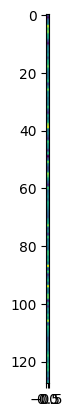

In [ ]:
# fake image generator first
disc.zero_grad()
noise = torch.randn(BATCH_SIZE, 128, 1, 1, device=device)
print(noise[0].shape)
plt.imshow(noise[0].cpu())

torch.Size([3, 128, 128])


<ipython-input-35-eb182bee4c39>:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  plt.imshow(invTrans(fake[0]).cpu().detach().T)


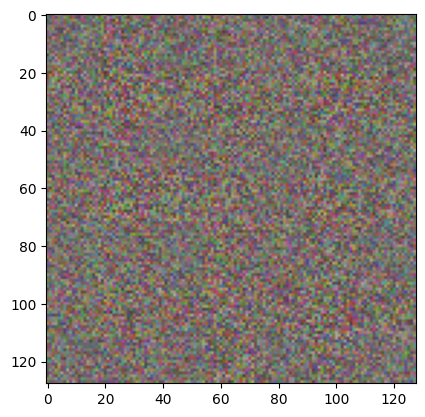

In [ ]:
fake = gen(noise)
print(fake[0].shape)
plt.imshow(invTrans(fake[0]).cpu().detach().T)

In [ ]:
label = torch.full((BATCH_SIZE,), real_label, dtype=torch.float, device=device)
label.fill_(fake_label)
print(label.shape)

torch.Size([64])


In [ ]:
# Forward pass through discriminator
output, output_style = disc(fake.detach())
print(output.shape, output_style.shape)

torch.Size([64, 1, 1, 1]) torch.Size([64, 27, 1, 1])


In [ ]:
# Calculate loss on fake batch
errD_fake = loss(output.squeeze(), label)
print(errD_fake)

tensor(0.8478, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


### next, real painting data discriminator

In [ ]:
disc.zero_grad()
img, style_label = next(iter(dataloader)).values()
print("Loaded batch")
style_label = style_label.to(device)
img_cpu = img.to(device)
label = torch.full((BATCH_SIZE,), real_label, dtype=torch.float, device=device)
# print(style_label, label, img_cpu)

KeyboardInterrupt: ignored

### testing for part b) training the generator

In [ ]:
gen.zero_grad()
    
label.fill_(real_label)  # fake labels are real for generator cost
output, output_style = disc(fake.detach())

logsoftmax = nn.LogSoftmax(dim=1)
unif = torch.full((BATCH_SIZE, n_class), 1/n_class) # 27 art styles
unif = unif.to(device)
print(unif)

errG = loss(output.squeeze(), label)
print(errG)
errG = errG + torch.mean(-torch.sum(unif * logsoftmax(output_style), 1))
print(errG)
print(output.mean().item())

tensor([[0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370],
        [0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370],
        [0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370],
        ...,
        [0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370],
        [0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370],
        [0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370]],
       device='cuda:0')
tensor(0.9155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(5.0713, device='cuda:0', grad_fn=<AddBackward0>)
0.4934428334236145


## Training Visualizations

### Training Loss

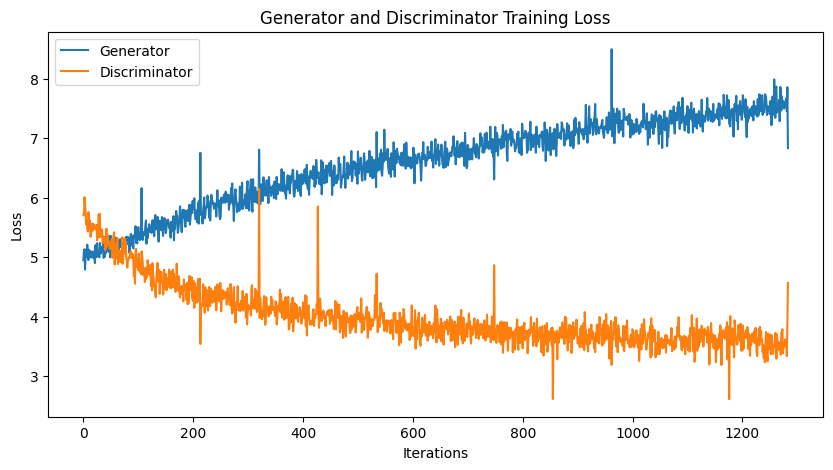

In [ ]:
# new one
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Training Loss")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# one thing that should happen often enough (depending on your data and initialisation) is that both discriminator and 
# generator losses are converging to some permanent numbers.

# This loss convergence would normally signify that the GAN model found some optimum, where it can't improve more,
# which also should mean that it has learned well enough.

### Discriminator Entropy

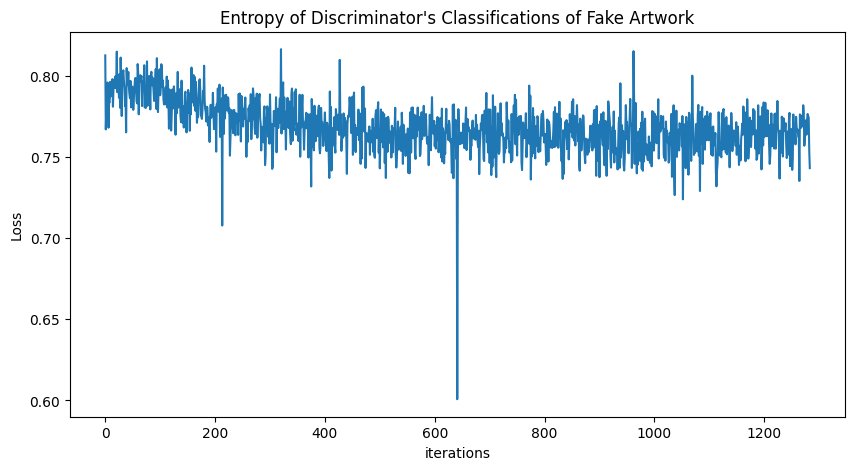

In [ ]:
# new. entropy struggling to decrease it seems
plt.figure(figsize=(10,5))
plt.title("Entropy of Discriminator's Classifications of Fake Artwork")
plt.plot(entropies)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

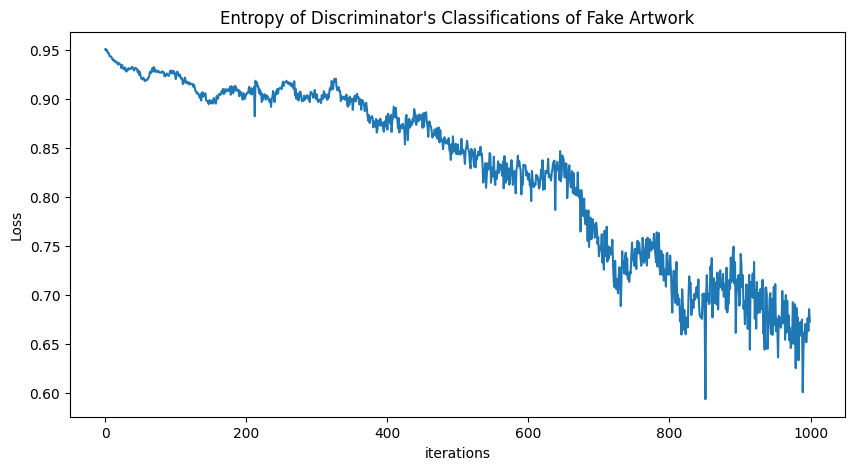

In [ ]:
entropies_cpu = [e.detach().cpu().numpy() for e in entropies]

plt.figure(figsize=(10,5))
plt.title("Entropy of Discriminator's Classifications of Fake Artwork")
plt.plot(entropies_cpu[:1000])
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

### Generator Images Animation

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(invTrans(i),(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(anim.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

### Real vs. Fake Paintings

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


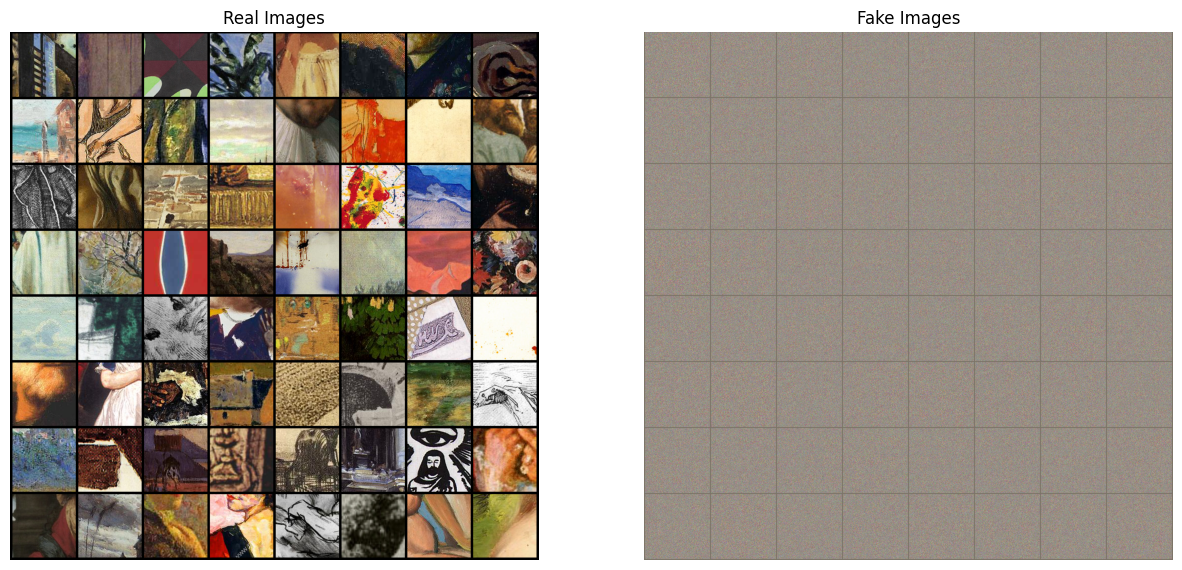

In [42]:
# temporarily using subset of dataloader for speed

# Grab a batch of real images from the dataloader
real_batch = next(iter(train_subset_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(invTrans(real_batch['images']).to(device)[:BATCH_SIZE], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(invTrans(img_list[-1]),(1,2,0)))
plt.show()

# evaluation:

## quantitative metrics

### a) Frechet Inception Distance (FID)

FID is a metric specifically used to quantitatively assess the quality of an image produced by a generative model, which improves upon the *inception score* by comparing the generated images with real images as opposed to only evaluating how well the generated images can be classified by a model (Inception v3) as a known object.



$$d^2((m, C), (m_w, C_w)) = ||m-m_w||_2^{2} + Tr(C+C_w - 2(CC_w)^{1/2}$$

Source: *GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium (Heusel et al. 2017)*

Essentially, FID captures the difference between the two Gaussian distributions underlying the synthetic and real images (m = feature-wise mean, C = covariance matrix, _w = real-world data). As it is a "spin-off" of inception score, it too is related to the Inception network—it assumes the two distributions are the activations of the pool_3 layer of InceptionNet for generated and real samples.


*Remark: It is recommended to use a minimum sample size of 10,000 to calculate the FID; otherwise the true FID of the generator is underestimated.* In fact, I think > 50,000 is preferred.

Implementation: Complicated. Requires loading pre-trained InceptionV3, resizing images, extracting its activations on both real and generated images, calculating mean and covariance of each, then feeding it into the formula above:

In [ ]:
# from pytorch_fid.inception import InceptionV3
# model = InceptionV3().to(device)
# model.eval(),

# with torch.no_grad():
#   pred = model(images)

# act = (get activations somehow)
# mu = np.mean(act, axis=0)
# sigma = np.cov(act, rowvar=False)

Instead, we will import a handy package to do this for us:

In [ ]:
!pip install clean-fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from cleanfid import fid

# Compute FID between two image folders
# score = fid.compute_fid(fdir1, fdir2)

# ^ PROBLEM: Our data is not local!
# also we'd have to generate 10,000+ images to use FID reliably

### b) Traditional image processing metrics

*Source: PyTorch Image Quality: Metrics for Image Quality Assessment*

In [ ]:
!pip install piq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.2/97.2 kB 11.2 MB/s eta 0:00:00


#### i) SSIM (structural similarity index measure)

In [ ]:
from piq import ssim

In [ ]:
x = torch.rand(64, 3, 128, 128, requires_grad=True)
y = torch.rand(64, 3, 128, 128)

ssim(x, y)

tensor(0.0050, grad_fn=<MeanBackward1>)

#### ii) PSNR (peak signal to noise ratio)

In [ ]:
from piq import psnr

In [ ]:
x = torch.rand(64, 3, 128, 128, requires_grad=True)
y = torch.rand(64, 3, 128, 128)

psnr(x, y)

tensor(7.7873, grad_fn=<MeanBackward1>)